<a href="https://colab.research.google.com/github/eborin/2015-MO810-SSL/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/2015-MO810-SSL/blob/main/01_pytorch_workflow.ipynb)

# 01. Model Generalization

This notebook delves into model generalization, focusing specifically on underfitting and overfitting in the training of PyTorch machine learning models.

## Objective

The main objective of this tutorial is to explore model generalization, with a focus on underfitting and overfitting.

Using a simple quadratic problem, we will analyze how different model architectures can underfit or overfit data depending on their capacity and hyperparameters.

## What we're going to cover

In this module we will use the standard PyTorch workflow (covered in the previous tutorial) to explore the performance of the model under different scenarios.

TODO: Revise the following table

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Generating the dataset** | We will use a quadratic function to generate a dataset from which we will try to fit our models. |
| **2. Building the model** | We will implement a PyTorch module that implements polynomial models. | 
| **3. Training and Evaluating Models** | Here we'll create code to train our models. | 
| **4. Model capacity vs gereralization** | Then, we will discuss what is model capacity and how it affects generalization. |
| **5. Handling overfitting** | Finally, we will discuss how we can handle model overfitting. |


## Where can you get help?

Besides discussing with your colleagues and the course professor.

There's also the [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## Importing PyTorch and setting-up the device

Now, let's import what we'll need for this module.

We're going to get `torch`, `torch.nn` (`nn` stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and `matplotlib`.

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Report PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Uncomment the next line if you want to force device = "cpu"
# device = "cpu"

print(f"Using device: {device}")

# Auxiliary function to set both the CPU and GPU seeds
def set_seed(seed):
    torch.manual_seed(seed)
    if device == "cuda": torch.cuda.manual_seed(seed)    

PyTorch version: 2.6.0+cu124
Using device: cuda


## 1. Generating the Dataset

We will use a simple quadratic problem to examine how various model architectures may underfit or overfit to this data based on their capacity and hyperparameters. 

In the following experiments we will use the following quadradic function to generate our data:

$f(x) = 2 \times x^{2} + 2 \times x + 4$

In real-world datasets, data is often collected by physical sensors (such as a camera CCD or an accelerometer) that may be influenced by factors unrelated to the phenomenon being modeled. 
For example, when capturing an image of a cat, the colors detected by the camera sensor can be affected by the colors of surrounding objects, even if those objects are not visible in the image. The sensor manufacturing process may also affect how it register the images. 
Additionally, environmental conditions like smoke or humidity can alter how light interacts with the camera sensor. 
Typically, these variations are minor and we not explicitly modeled by the machine learning model. Instead, they are treated as noise—random fluctuations in the sampling process — which the model accounts for stochastically.

In the following experiment, we will introduce noise into our data using a random function to simulate unknown factors that may be present in real-world datasets. 
Specifically, for each sample, we will add noise drawn from a uniform distribution between -2.0 and 2.0. 
To achieve this, we will generate a dataset based on the following equation:

$f(x) = 2 \times x^{2} + 2 \times x + 4 + random.uniform(-2.0,2.0)$

For now, we will use the suffix `_all` to indicate that this contains all the samples in the dataset.
The following code generates our dataset.

In [39]:
len(X_all)

1300

In [38]:
# Our quadractic function
def f(x): return 2*x*x + 2*x + 4

# Lets set our random number generator seed
set_seed(42)

# Generate the X_pop data (the features)
x_start, x_end, x_step = -3.0, 10.0, 0.01
X_all = torch.arange(x_start, x_end, x_step,dtype=torch.float64,device="cpu").unsqueeze(dim=1)

# Generate the corresponding y values (the labels)
y_all_clean = f(X_all)

# Add random values to mimic data sampling noise: random.uniform(-2.0,2.0)
y_all = y_all_clean + (torch.rand(size=X_all.shape, device="cpu")*4.0 - 2.0) 

# Print the first 10 samples
print("X_all[:10]:",X_all[:10])
print("y_all[:10]:",y_all[:10])

# Send the data to the target device
X_all = X_all.to(device)
y_all_clean = y_all_clean.to(device)
y_all = y_all.to(device)


X_all[:10]: tensor([[-3.0000],
        [-2.9900],
        [-2.9800],
        [-2.9700],
        [-2.9600],
        [-2.9500],
        [-2.9400],
        [-2.9300],
        [-2.9200],
        [-2.9100]], dtype=torch.float64)
y_all[:10]: tensor([[17.5291],
        [17.5602],
        [15.3323],
        [17.5390],
        [15.1650],
        [15.9086],
        [14.4335],
        [16.4844],
        [16.9759],
        [13.6489]], dtype=torch.float64)


### Visualizing the dataset

Now, lets build a function to show the data on a chart. 
We will start with a function that can plot our dataset samples (light blue) and a foreground line (our generative function). 

In [40]:
def plot_dataset_samples_v1(background_samples=None, # Tuple (X, y, "title") with information about the dataset samples
                            background_line=None, # Tuple (X, y, "title") with information to plot a background (gree) line.
                            filename=None):
    # Create the matplotlib chart
    plt.figure() 
    # Set the y-axis range to [-1,29]
    # plt.ylim((-1,29)) 
    if not background_samples is None:
        # If background samples is defined, plot it using lightblue dots
        plt.plot(background_samples[0].cpu(), background_samples[1].cpu(), "o", color="lightblue", label=background_samples[2])
    if not background_line is None:
        # If background line is defined, plot it using a green line
        plt.plot(background_line[0].cpu(),background_line[1].cpu(),"-", color="green", label=background_line[2])
    # Add legend
    plt.legend()
    if not filename is None:
        # If a filename is provided, save the chart.
        plt.savefig(filename,bbox_inches='tight',dpi=600) # Save the chart
    plt.show()
    plt.close()  

Great, lets plot our dataset!

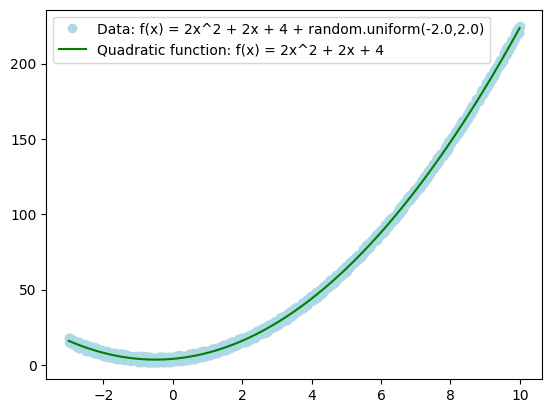

In [41]:
plot_dataset_samples_v1(background_samples=(X_all,y_all,"Data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        filename="dataset-all_samples.png")

### Split data into training and test sets 

Before we train and evaluate our models, we need to split the dataset.
However, before we split our dataset, we will randomly select a few samples (16 for now) to mimic situations in which we do not have much data to work with (this is usually the case in many real-world problems). 

In [43]:
# Sample n_samples values from the (X,y) dataset.
def sample_values_from_dataset(X, y, n_samples, random_seed=1969):
    # Generate random indices
    set_seed(random_seed)
    random_indices = torch.randperm(n=X_all.shape[0], device="cpu")
    random_indices = random_indices.to(device)
    chosen_indices = random_indices[:n_samples]
    return X[chosen_indices,:], y[chosen_indices,:]

# Select 16 samples using the 16 random indices
X, y = sample_values_from_dataset(X_all, y_all, 16)

In [42]:
len(X)

16




One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

We can create them by splitting our `X` and `y` tensors.

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

The following code partitions our dataset:

> **Hint:** The scikit learn library contains a function called `train_test_split` that is often used to perform this split.

> **Note:** For our purposes, the next experiments will assign 50% (8) of the samples to the training set, while the remaining 50% will be divided by the validation and the test set. Nonetheless, as discussed previously, usually 60% to 80% of the data is assigned to the training set.


In [44]:
# Select 8, 4, and 4 samples for the training, validation and test sets, respectively
X_train, y_train = X[0:8], y[0:8]
X_val, y_val = X[8:12], y[8:12]
X_test, y_test = X[12:16], y[12:16]

print(f"Train set shape     : X = {X_train.shape}, y = {y_train.shape}")
print(f"Validation set shape: X = {X_val.shape}, y = {y_val.shape}")
print(f"Test set shape      : X = {X_test.shape}, y = {y_test.shape}")

Train set shape     : X = torch.Size([8, 1]), y = torch.Size([8, 1])
Validation set shape: X = torch.Size([4, 1]), y = torch.Size([4, 1])
Test set shape      : X = torch.Size([4, 1]), y = torch.Size([4, 1])


Notice that our training set contains 8 samples, while the validation and the test sets contain 4 each.


### Visualizing the training, validation, and test sets

Now that we partitioned our dataset, lets plot the partitions on the chart. 
To do so, we will improve our plot function to also plot the train, validation, and test samples using different markers. 

In [45]:
def plot_dataset_samples_v2(train_samples=None,      # Tuple (X, y, "title") with information about the training samples (blue dots)
                            val_samples=None,        # Tuple (X, y, "title") with information about the validation samples (yellow dots)
                            test_samples=None,       # Tuple (X, y, "title") with information about the test samples (orange triangles)
                            background_samples=None, # Tuple (X, y, "title") with information about the dataset samples
                            background_line=None,    # Tuple (X, y, "title") with information to plot a background (gree) line.
                            filename=None):
    # Create the matplotlib chart
    plt.figure() 
    # Set the y-axis range to [-1,29]
    #plt.ylim((-1,29)) 
    if not background_samples is None:
        # If background samples is defined, plot it using lightblue dots
        plt.plot(background_samples[0].cpu(), background_samples[1].cpu(), "o", color="lightblue", label=background_samples[2])
    if not background_line is None:
        # If background line is defined, plot it using a green line
        plt.plot(background_line[0].cpu(),background_line[1].cpu(),"-", color="green", label=background_line[2])
    if not train_samples is None:
        plt.plot(train_samples[0].cpu(),train_samples[1].cpu(),"o", color="blue",label=train_samples[2])
    if not val_samples is None:
        plt.plot(val_samples[0].cpu(),val_samples[1].cpu(),"o", color="yellow",label=val_samples[2])
    if not test_samples is None:
        plt.plot(test_samples[0].cpu(),test_samples[1].cpu(),"^", color="orange",label=test_samples[2])

    # Add legend
    plt.legend()
    if not filename is None:
        # If a filename is provided, save the chart.
        plt.savefig(filename,bbox_inches='tight',dpi=600) # Save the chart
    plt.show()
    plt.close()  

Now, lets plot our partitions

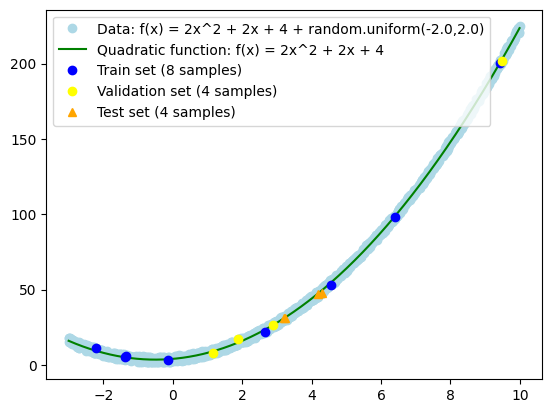

In [46]:
plot_dataset_samples_v2(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        test_samples=(X_test,y_test,f"Test set ({len(X_test)} samples)"),
                        background_samples=(X_all,y_all,"Data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"))


Nice! We can see the samples that were selected to train the model (blue dots), to validate the training process (yellow dots), and to test the final model (orange triangles).

### Summary

In this section, we discussed how to create and visualize our dataset. 
We may reuse the following functions later to create alternative partitionings and to visualize our dataset partitions:

* `X, y = sample_values_from_dataset(X_all, y_all, nsamples)`: extract `nsamples` from the original data. (`nsamples=16` for now)
* `X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)`: partition the data into train, validation, and test subsets.

## 2. Building the model

In this section, we will discuss how to create the models used in this tutorial. 

To analyze the impact of "model capacity" on generalization, we will explore a set of polynomial models. 
These models represent polynomials where the coefficients serve as the model's parameters. 
The linear model examined in the previous tutorial is a special case of a polynomial model with a degree equals to 1.

A polynomial model implements the following function:

$f(x) = p_d \times x^{d} + p_{d-1} \times x^{d-1} + \cdots + p_{1} \times x^{1} + p_{0} \times x^{0}$

Notice that for $d=1$, the function is a linear function:

$f(x) = p_1 \times x^{1} + p_{0} \times x^{0} = p_1 \times x^{1} + p_{0}$

The following code implements a general polynomial model on PyTorch. 
Notice that the constructor expects the polynomial degree $d$. 



In [47]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, polynomial_degree):
        super().__init__()
        self.d = polynomial_degree
        # Coefficients is a list of parameters: p0, p1, ..., pd
        self.coefficients = nn.ParameterList([nn.Parameter(torch.randn(1, dtype=torch.float64)) for i in range(self.d+1)])
    
    # Forward method (apply the model to a set of samples X)
    def forward(self, X):
        # Create an accumulator variable and initialize it with zeros. 
        # Make sure it resides on the same device as data being processed, i.e., X.
        result = torch.zeros(size=(X.shape[0],1), device=X.device)
        # Accumulates the product of all coefficients by the respective power of x.
        for i in range(self.d+1):
            result = result + (torch.pow(X,i) * self.coefficients[i])
        # Returns the result
        return result

    # Returns a human-readable string representation of the model. This is reported by the print() function.
    def __str__(self):
        equation = f"f(x) = {self.coefficients[self.d].item():.4f} * x^{self.d}"
        for i in range(self.d-1, -1, -1):
            equation = equation + f" + {self.coefficients[i].item():.4f} * x^{i}"
        return equation

# Lets set the random number generator seed to ensure we always generate the same model whenever we re-execute this code block.
set_seed(1969)

# Create a quadratic model
our_model = PolynomialRegressionModel(polynomial_degree=2).to(device)

# Print our model
print("-- Our linear model --")
print("Our model function:", our_model)

-- Our linear model --
Our model function: f(x) = -0.4297 * x^2 + -0.4630 * x^1 + -0.0078 * x^0


We can also inspect our model by printing its parameters, as discussed in the previous tutorial.

In [48]:
# List the model parameters 
our_model.state_dict()

OrderedDict([('coefficients.0',
              tensor([-0.0078], device='cuda:0', dtype=torch.float64)),
             ('coefficients.1',
              tensor([-0.4630], device='cuda:0', dtype=torch.float64)),
             ('coefficients.2',
              tensor([-0.4297], device='cuda:0', dtype=torch.float64))])

Ok, we can test our model now. It has not been trained, hence, the results produced by it may not be good.

### Visualizing the model

Before we run our model, lets improve our plot function to show our model and the values produced by it.


In [49]:
def plot_dataset_samples_v3(train_samples=None, # Tuple (X, y, "title") with information about the training samples (blue dots)
                            val_samples=None, # Tuple (X, y, "title") with information about the validation samples (yellow dots)
                            test_samples=None, # Tuple (X, y, "title") with information about the test samples (orange triangles)
                            background_samples=None, # Tuple (X, y, "title") with information about the dataset samples
                            background_line=None, # Tuple (X, y, "title") with information to plot a background (gree) line.
                            model_line=None, # Tuple (start, end, step, model, "title") with a) start, end, and step values to plot the line; b) the pytorch model; and c) a title for the chart legend. The model line will be plotted with a red line.
                            model_results=None, # Tuple (X, y, "title") with a) with samples produced by the model. They will be plotted as purple crosses.
                            max_equation_size = 60, # Maximum number of characters when showing the model equation.
                            yrange=None, # Tuple (min, max) with Y-axis range 
                            filename=None):
    # Create the matplotlib chart
    plt.figure() 
    if not background_samples is None:
        # If background samples is defined, plot it using lightblue dots
        plt.plot(background_samples[0].cpu(), background_samples[1].cpu(), "o", color="lightblue", label=background_samples[2])
    if not background_line is None:
        # If background line is defined, plot it using a green line
        plt.plot(background_line[0].cpu(),background_line[1].cpu(),"-", color="green", label=background_line[2])
    if not train_samples is None:
        plt.plot(train_samples[0].cpu(),train_samples[1].cpu(),"o", color="blue",label=train_samples[2])
    if not val_samples is None:
        plt.plot(val_samples[0].cpu(),val_samples[1].cpu(),"o", color="yellow",label=val_samples[2])
    if not test_samples is None:
        plt.plot(test_samples[0].cpu(),test_samples[1].cpu(),"^", color="orange",label=test_samples[2])
    if not model_line is None:
        # The following code generates a set of data points, compute the labels 
        # using the model, and plot them as a red line.
        start,end,step = model_line[0], model_line[1], model_line[2]
        model = model_line[3]
        X_values = torch.arange(start, end, step, device=device).unsqueeze(1)
        y_hat = model(X_values).cpu()
        # Retrieve the model function as text to format the legend.
        model_equation = str(model)
        if len(model_equation) > max_equation_size:
            # Truncate the string that shows the model function  
            chunk_sz = max_equation_size//2
            model_equation = model_equation[:chunk_sz+4] + "..." + model_equation[-(chunk_sz-4):]
        plt.plot(X_values.cpu().detach(),y_hat.detach(),"-", color="red", label="Model "+model_equation)
    if not model_results is None:
        plt.plot(model_results[0].cpu(),model_results[1].cpu(),"X", color="purple", label=model_results[2])

    # Add legend
    plt.legend()
    if not filename is None:
        # If a filename is provided, save the chart.
        plt.savefig(filename,bbox_inches='tight',dpi=600) # Save the chart
    if not yrange is None:
        plt.ylim(yrange)

    plt.show()
    plt.close()  




Lets run the model on the test set and plot it.

Model  f(x) = -0.4297 * x^2 + -0.4630 * x^1 + -0.0078 * x^0


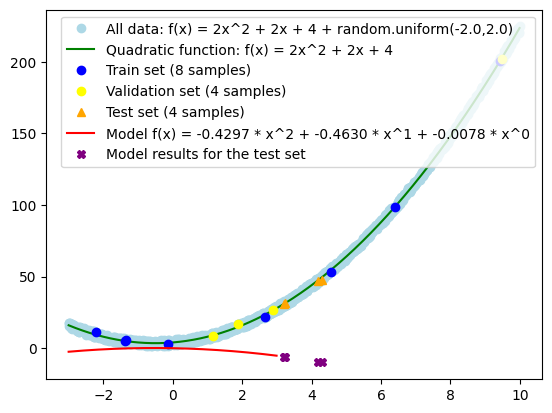

In [50]:
# Run the model on the test set.
our_model.eval()
with torch.inference_mode(): 
    y_hat = our_model(X_test)

print("Model ", our_model)
plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        test_samples=(X_test, y_test,f"Test set ({len(X_test)} samples)"),
                        background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        model_line=(-3.0,3.0,0.01,our_model),
                        model_results=(X_test, y_hat.detach(),"Model results for the test set"))



Notice that the model peforms poorly, as the results produced for the test set (purple crosses) are very far from the correct (expected) labels (orange triangles).

### Summary

We discussed how to create polynomial models using PyTorch and how to plot them. The following command will be used latter to instantiate different polynomial models:

>  * `our_model = PolynomialRegressionModel(polynomial_degree=2)`

The next step is to train our models using the training set.

## 3. Training the model

Since we plan to train several polynomial models, lets create a function to facilitate our task. 
This function, called `train_model`, will be used to train our models. The following code shows the first version of the `train_model` function.

Notice that the training loop is very similar to the one developed in the previous tutorial. 
It consists of an outer loop that iterates over the training epochs. 
For each epoch, it computes the gradients and updates the model parameters using the training set (X_train, y_train), the MAE loss and the SGD optimizer. 
Then it evaluates the model performance using another set of samples, the validation samples. 
Both the training and the validation losses are registered on python lists and returned for posterior analysis.

In [51]:
def train_model_v1(model, 
                   X_train, y_train, 
                   X_val, y_val,
                   learning_rate = 0.01,
                   number_of_epochs = 10,
                   verbosity_skip_level = 1): # Print loss at every 'verbosity_skip_level' epochs.

    # Create the loss function
    loss_fn = nn.L1Loss() # The L1Loss is the MAE

    # Create the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    # Create empty loss and epoch indices lists to track values
    train_loss_values = []
    val_loss_values = []
    epoch_indices = []

    for epoch in range(number_of_epochs):
        # -- Update the parameters using the training set -- #

        # Put model in training mode (this is the default state of a model)
        model.train()
        # 1. Forward pass on train data using the forward() method inside 
        y_hat = model(X_train)
        # 2. Calculate the loss (how different are our models predictions to the ground truth)
        loss = loss_fn(y_hat, y_train)
        # 3. Zero grad of the optimizer
        optimizer.zero_grad()
        # 4. Loss backwards
        loss.backward()
        # 5. Progress the optimizer
        optimizer.step()

        # -- Check performance on validation set -- #

        # Put the model in evaluation mode
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass on validation data
            val_hat = model(X_val)
            # 2. Caculate loss on validation data
            val_loss = loss_fn(val_hat, y_val)
            # Register the training and validation losses for later analysis. 
            epoch_indices.append(epoch)
            train_loss_values.append(float(loss.detach().cpu().numpy()))
            val_loss_values.append(float(val_loss.detach().cpu().numpy()))

            # Print out what's happening
            if (verbosity_skip_level > 0) and (epoch % verbosity_skip_level == 0):
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Validation Loss: {val_loss} ")
    # Return the training and validation losses
    return epoch_indices, train_loss_values, val_loss_values

Ok. Lets create a polynomial model, visualize it, train it, and visualize again.

** Model before training **
Model f(x) = -0.4297 * x^2 + -0.4630 * x^1 + -0.0078 * x^0


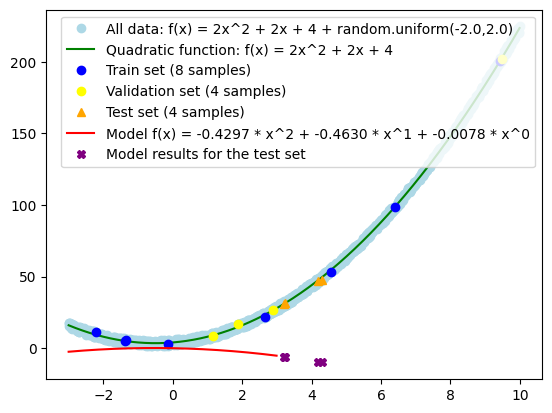

** Training the model for 1000 epochs **
Epoch: 0 | MAE Train Loss: 59.88996709575205 | MAE Validation Loss: 70.74146878691651 
Epoch: 100 | MAE Train Loss: 2.588467269576259 | MAE Validation Loss: 5.837524572908899 
Epoch: 200 | MAE Train Loss: 3.657177874962593 | MAE Validation Loss: 4.799894854321248 
Epoch: 300 | MAE Train Loss: 1.5591667400774107 | MAE Validation Loss: 7.7736484304585955 
Epoch: 400 | MAE Train Loss: 1.4179973009776765 | MAE Validation Loss: 7.0584229143833515 
Epoch: 500 | MAE Train Loss: 3.580986722270254 | MAE Validation Loss: 2.780843111501956 
Epoch: 600 | MAE Train Loss: 3.28406621198904 | MAE Validation Loss: 2.502443834886214 
Epoch: 700 | MAE Train Loss: 3.1303443231140804 | MAE Validation Loss: 2.6518815705111694 
Epoch: 800 | MAE Train Loss: 2.836977366114085 | MAE Validation Loss: 2.968732815511148 
Epoch: 900 | MAE Train Loss: 2.203846080176592 | MAE Validation Loss: 3.7206226983236492 
** Model after training for 100 epochs with learning rate = 0.1 *

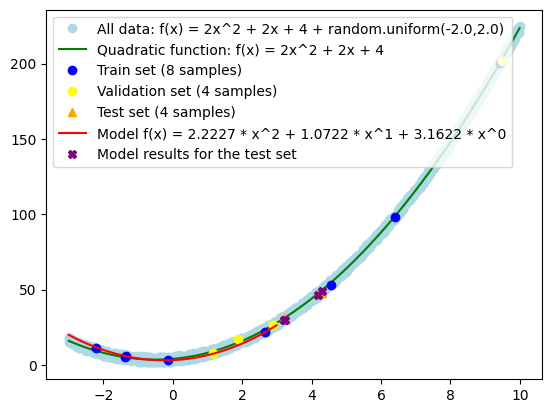

In [52]:
# Set the random seed to ensure consistency accross multiple executions of this code block
set_seed(1969)

# Create the model
new_model = PolynomialRegressionModel(polynomial_degree=2).to(device)

# Visualize it: before training
print("** Model before training **")
print("Model", new_model)

new_model.eval()
with torch.inference_mode(): 
    y_hat = new_model(X_test)

plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        test_samples=(X_test, y_test,f"Test set ({len(X_test)} samples)"),
                        background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        model_line=(-3.0,3.0,0.01,new_model),
                        model_results=(X_test, y_hat.detach(),"Model results for the test set"))

# Train it
print("** Training the model for 1000 epochs **")
epoch_indices, train_loss_values, val_loss_values = train_model_v1(new_model, X_train, y_train, X_val, y_val, 
                                                                   learning_rate = 0.01, number_of_epochs = 1000, 
                                                                   verbosity_skip_level = 100)

# Visualize it again: after training
print("** Model after training for 100 epochs with learning rate = 0.1 **")
print("Model", new_model)

new_model.eval()
with torch.inference_mode(): 
    y_hat = new_model(X_test)

plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        test_samples=(X_test, y_test,f"Test set ({len(X_test)} samples)"),
                        background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        model_line=(-3.0,3.0,0.01,new_model),
                        model_results=(X_test, y_hat.detach(),"Model results for the test set"))



We can see that the model is performing much better after training. 

Lets take a look at the train and validation losses over the epochs:




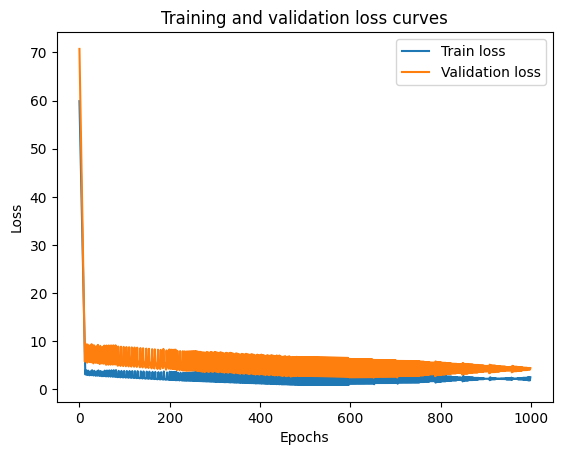

In [53]:
# Plot the training and validation losses over the training epochs.
plt.plot(epoch_indices, train_loss_values, label="Train loss")
plt.plot(epoch_indices, val_loss_values, label="Validation loss")
plt.title("Training and validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Notice that both curves go down over the epochs -- This is not always the case, sometimes the model overspecializes to the training data, causing the validation loss to increase overtime while the training loss continues to decrease.

### Learning rate vs loss convergence

The learning rate hyperparameter is used by the optimizer to weight how much the gradient will affect the parameters at each step. 
It is basically a factor that is multiplied by the gradient before adjusting (adding the gradients to) the parameters. 
As a consequence, the larger the learning rate, the larger the steps taken by the optimizer when adjusting the parameters.

Large steps might help us reach our goal sooner (with fewer steps), however, if the steps are too large, the learn process may overshoot, taking the parameters to values that are beyond optimal. 

There are some learning approaches that try to automatically adjust the learning rate over the course of the trainin process. 
Nonetheless, choosing the ideal learning rate or even the right approach might not be a trivial task. 
To illustrate how the learning rate affects the training, we will execute the previous experiment again, but with different learning rates.

To simplify our analysis, lets focus on the train loss curves. 
The following code creates polynomial models and trains them for 1000 epochs using different learning rates: 0.0001, 0.001, 0.01, 0.1, and 1.0.

For each learning rate value, it also prints the maximum and minimum loss values found over the epochs and the loss achieved in the first 5 epochs.


-- Training with learning rate = 1.0
   Train loss on first 5 epochs: [59.88996709575205, 378.5494890981903, 59.60715703325202, 378.76836127006527, 59.32434697075197]
   Train loss on last 5 epochs: [380.3302520642484, 57.62748659575173, 380.3302520642484, 57.62748659575173, 380.3302520642484]
   Max train loss: 380.3302520642484
   Min train loss: 57.62748659575173
-- Training with learning rate = 0.1
   Train loss on first 5 epochs: [59.88996709575205, 16.09419322975204, 28.4095462201902, 16.06591222350204, 28.4314334373777]
   Train loss on last 5 epochs: [25.5937310957519, 18.202042770248106, 25.5937310957519, 18.202042770248106, 25.5937310957519]
   Max train loss: 59.88996709575205
   Min train loss: 14.511707339114704
-- Training with learning rate = 0.01
   Train loss on first 5 epochs: [59.88996709575205, 55.51038970915205, 51.130812322552046, 46.75123493595205, 42.371657549352044]
   Train loss on last 5 epochs: [2.500509003815437, 1.8649434884265879, 2.5011147154154356, 1.86

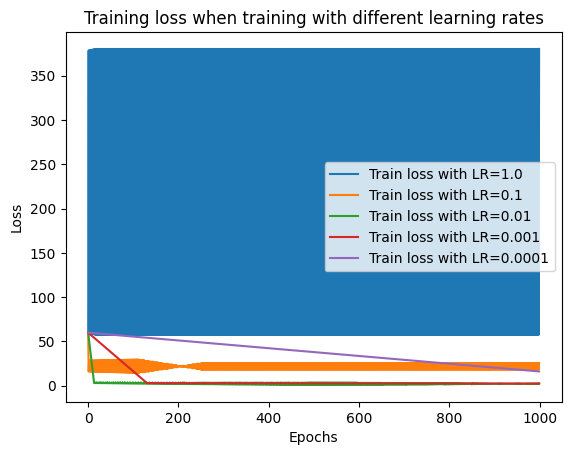

In [54]:
for learning_rate in [1.0, 0.1, 0.01, 0.001, 0.0001]: 

    # Set the random seed to ensure all models start from the same random parameters
    set_seed(1969)

    # Create the model
    new_model = PolynomialRegressionModel(polynomial_degree=2).to(device)

    # Train it for 1000 epochs
    print(f"-- Training with learning rate = {learning_rate}")
    epoch_indices, train_loss_values, val_loss_values = train_model_v1(new_model, X_train, y_train, X_val, y_val, 
                                                                    learning_rate = learning_rate, number_of_epochs = 1000, 
                                                                    verbosity_skip_level = 0)
    # Print statistics
    print("   Train loss on first 5 epochs:", train_loss_values[0:5])
    print("   Train loss on last 5 epochs:", train_loss_values[-5:])
    print("   Max train loss:", max(train_loss_values))
    print("   Min train loss:", min(train_loss_values))

    # Plot the curves
    plt.plot(epoch_indices, train_loss_values, label=f"Train loss with LR={learning_rate}")

# Format the chart
plt.title(f"Training loss when training with different learning rates")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Notice that a lower learning rate results in a slower reduction of model error (loss), requiring more epochs for convergence.

For instance, with a learning rate of 0.0001 (purple curve), it takes 1,000 epochs to decrease the loss from approximately ~8.81 to ~8.09 (these values may vary across devices).

Conversely, when the learning rate is too high (e.g., 1.0, as shown by the blue curve), the optimizer may overshoot, making adjustments that exceed optimal values. 
This can cause the learning process to oscillate back and forth or even diverge entirely.

For this particular problem and data, a learning rate = 0.1 seems to work best, as it converges faster than the other and reaches the best training loss in 1000 epochs.

### Learning rate scheduling

In many cases, a learning rate scheduler can be used to automatically adjust the learning rate over training epochs.

The following code presents an updated version of the training function that incorporates this approach. 
In this example, we utilize the PyTorch `PolynomialLR` scheduler, which gradually modifies the learning rate based on a polynomial factor.

In [55]:
def train_model_v2(model, 
                   X_train, y_train, 
                   X_val, y_val,
                   learning_rate = 0.001,
                   number_of_epochs = 10,
                   verbosity_skip_level = 1): # Print loss at every 'verbosity_skip_level' epochs.

    # Create the loss function
    loss_fn = nn.L1Loss() # The L1Loss is the MAE

    # Create the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    # (1) Create a learning rate (LR) scheduler.
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, cooldown=2, threshold=0.01)
    #lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=1.0)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    #lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=900, gamma=0.1)
    #lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, 
    #                                                 end_factor=0.000001, 
    #                                                 total_iters=number_of_epochs)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, 
                                                         total_iters=number_of_epochs, 
                                                         power=4.0)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Create empty loss and epoch indices lists to track values
    train_loss_values = []
    val_loss_values = []
    epoch_indices = []

    for epoch in range(number_of_epochs):
        # -- Update the parameters using the training set -- #

        # Put model in training mode (this is the default state of a model)
        model.train()
        # 1. Forward pass on train data using the forward() method inside 
        y_hat = model(X_train)
        # 2. Calculate the loss (how different are our models predictions to the ground truth)
        loss = loss_fn(y_hat, y_train)
        # 3. Zero grad of the optimizer
        optimizer.zero_grad()
        # 4. Loss backwards
        loss.backward()
        # 5. Progress the optimizer
        optimizer.step()

        # -- Check performance on validation set -- #

        # Put the model in evaluation mode
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass on test data
            val_hat = model(X_val)
            # 2. Caculate loss on test data
            val_loss = loss_fn(val_hat, y_val.type(torch.float))
            epoch_indices.append(epoch)
            train_loss_values.append(float(loss.detach().cpu().numpy()))
            val_loss_values.append(float(val_loss.detach().cpu().numpy()))

            # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
            # (2) Adjust the learning rate at the end of each epoch
            lr_scheduler.step()
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

            # Print out what's happening
            if (verbosity_skip_level > 0) and (epoch % verbosity_skip_level == 0):
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Validation Loss: {val_loss} ")
    return epoch_indices, train_loss_values, val_loss_values

Notice that this code contains a new object (1), identified by the variable `lr_scheduler`, that adjusts the learning rate during the training process (2). 

Lets repeat the previous experiment using this new training function and check how the training and validation losses behave.

-- Training with learning rate = 1.0
   Train loss on first 5 epochs: [59.88996709575205, 378.5494890981903, 57.85908161817157, 377.02465327972743, 55.84092455639778]
   Train loss on last 5 epochs: [0.43497780375340833, 0.4349778014529085, 0.43497780051062124, 0.4349778002124726, 0.4349778001535806]
   Max train loss: 378.5494890981903
   Min train loss: 0.4349629538751435
-- Training with learning rate = 0.1
   Train loss on first 5 epochs: [59.88996709575205, 16.09419322975204, 28.234738678682156, 15.891741796553287, 28.082691052587563]
   Train loss on last 5 epochs: [0.5560353060932754, 0.5560353059346168, 0.5560353058696321, 0.5560353058490706, 0.556035305845004]
   Max train loss: 59.88996709575205
   Min train loss: 0.556035305845004
-- Training with learning rate = 0.01
   Train loss on first 5 epochs: [59.88996709575205, 55.51038970915205, 51.14830437214806, 46.803658634859985, 42.476400152359915]
   Train loss on last 5 epochs: [1.8981139232060182, 1.8981139231901536, 1.8981

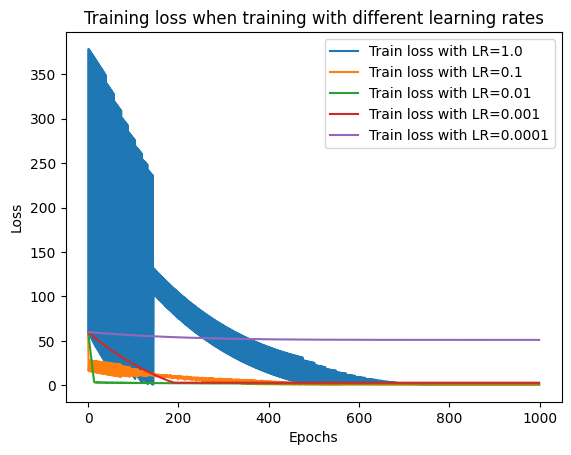

In [56]:

for learning_rate in [1.0, 0.1, 0.01, 0.001, 0.0001]: 

    # Set the random seed to ensure all models start from the same random parameters
    set_seed(1969)

    # Create the model
    new_model = PolynomialRegressionModel(polynomial_degree=2).to(device)

    # Train it for 1000 epochs
    print(f"-- Training with learning rate = {learning_rate}")
    epoch_indices, train_loss_values, val_loss_values = train_model_v2(new_model, X_train, y_train, X_val, y_val, 
                                                                    learning_rate = learning_rate, number_of_epochs = 1000, 
                                                                    verbosity_skip_level = 0)
    # Print statistics
    print("   Train loss on first 5 epochs:", train_loss_values[0:5])
    print("   Train loss on last 5 epochs:", train_loss_values[-5:])
    print("   Max train loss:", max(train_loss_values))
    print("   Min train loss:", min(train_loss_values))

    # Plot the curves
    plt.plot(epoch_indices, train_loss_values, label=f"Train loss with LR={learning_rate}")

# Format the chart
plt.title(f"Training loss when training with different learning rates")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Notice that the blue curve (training loss with LR=1.0) becomes more stable and converges over time. 
Also, notice that the red curve (LR=0.001) takes longer to decrease. 
This happens because the scheduler employed in the training process gradually decreased the learning rates over the epochs.

## 4. Model capacity vs. Generalization

Model capacity is the ability a model has to ﬁt a wide variety of functions (or data patterns)! As a consequence, higher capacity models are capable of solving more complex problems.
> E.g.: A quadratic model has higher capacity than a linear model. 

The higher the model capacity, the easier it is to fit the model to the training data.

The greater flexibility of higher capacity models allows us to deeply specialize the model to the training dataset. 
However, if the training set contains noise (small errors), we might be learning both the underlying data function and the noise present on the training dataset. 
To illustrate this problem, we will train multiple models (with different capacities) on our noisy training set.



First, lets create the models. For each model, we also select a learning rate we found to work best for the model.

In [57]:
set_seed(1969)

# Create a dictionary with several models, each one with a different polynomial degree (different capacity). 
# For each model, we also select a learning rate we found to work best for the model.
models = {}
for polynomial_degree, lr in [(1, 0.1), (2, 0.1), (4, 0.05)]:
    print(f"Creating a polynomial model with degree = {polynomial_degree}")
    model = PolynomialRegressionModel(polynomial_degree=polynomial_degree).to(device)
    models[polynomial_degree] = { "model": model, "lr": lr }


Creating a polynomial model with degree = 1
Creating a polynomial model with degree = 2
Creating a polynomial model with degree = 4


Now, lets train these models on the training set for 20000 epochs.

In [58]:
import numpy as np # Import numpy to use its argmin function

# For each model, train it
for degree, model_info in models.items():
    print(f"** Training model with polynomial degree = {degree} **")
    # Train it
    epoch_indices, train_losses, val_losses = train_model_v2(model_info["model"], X_train, y_train, X_val, y_val, 
                                                             learning_rate = model_info["lr"], 
                                                             number_of_epochs = 20000, verbosity_skip_level = 0)
    # Save the training losses
    models[degree]["epoch_indices"] = epoch_indices
    models[degree]["train_losses"] = train_losses
    models[degree]["val_losses"] = val_losses

    # Print a summary of the training losses
    print(f" - Train loss on first 5 epochs:", train_losses[0:5])
    print(f" - Train loss on last  5 epochs:", train_losses[-5:])
    print(f" - Min train loss     :", min(train_losses), f"(Best epoch = {np.argmin(train_losses)})")

** Training model with polynomial degree = 1 **
 - Train loss on first 5 epochs: [50.96001541826842, 50.35713479326842, 49.75437473535052, 49.15173522643009, 48.549216248424344]
 - Train loss on last  5 epochs: [19.23085142114141, 19.23085142114141, 19.23085142114141, 19.23085142114141, 19.23085142114141]
 - Min train loss     : 19.23085142114141 (Best epoch = 19990)
** Training model with polynomial degree = 2 **
 - Train loss on first 5 epochs: [47.78138969600862, 5.948234978749019, 36.28428255786592, 9.545803016319445, 32.03896235312602]
 - Train loss on last  5 epochs: [0.3316362164375747, 0.33163621643757113, 0.33163621643757, 0.33163621643757, 0.33163621643757]
 - Min train loss     : 0.3316362164374464 (Best epoch = 19990)
** Training model with polynomial degree = 4 **
 - Train loss on first 5 epochs: [1071.8960420623994, 78497.50357804225, 1880.3419429057667, 78481.412766602, 1864.2819350432994]
 - Train loss on last  5 epochs: [1.561330934911022, 1.5613309348067668, 1.5613309

Notice that the polynomial model with degree = 4 achieved a lower training loss. 

The following code plots the training curves.

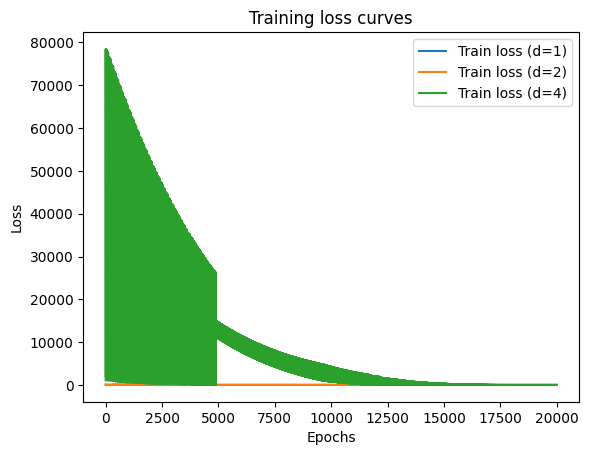

In [59]:
# Lets plot the training losses
for degree, model_info in models.items():
    # Plot the training loss curve
    plt.plot(model_info["epoch_indices"], model_info["train_losses"], 
             label=f"Train loss (d={degree})")

# Configure and show the chart
plt.title(f"Training loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

It looks like the training loss has converged for all models.

Now, let's plot them to visualize their behavior.

Model with polynomial degree = 1
Trained model f(x) = 11.9461 * x^1 + 21.7917 * x^0


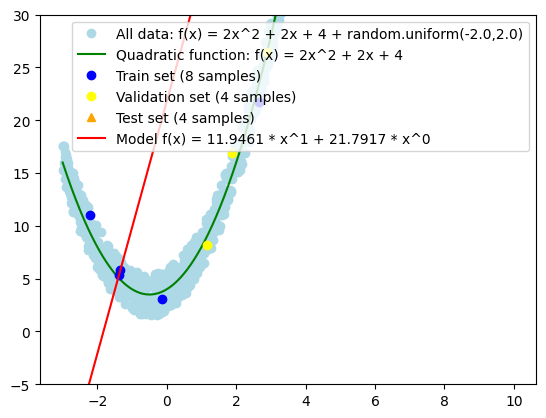

Model with polynomial degree = 2
Trained model f(x) = 2.0844 * x^2 + 1.2876 * x^1 + 3.5925 * x^0


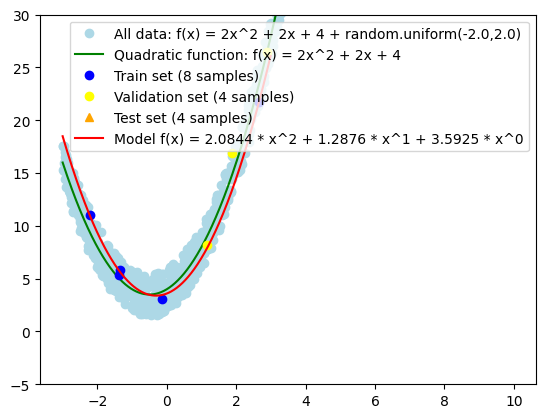

Model with polynomial degree = 4
Trained model f(x) = -0.0213 * x^4 + 0.2480 * x^3 + 1.8050 * x^2 + -0.2669 * x^1 + 3.0303 * x^0


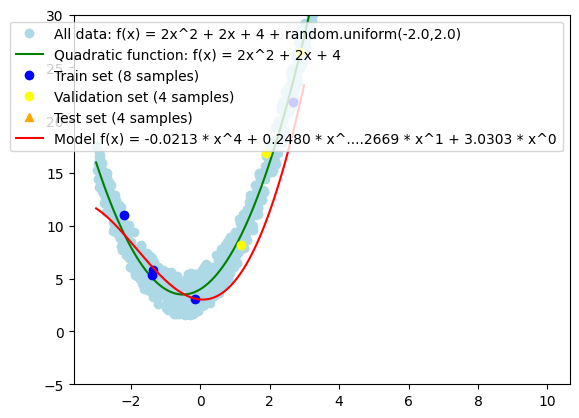

In [60]:
# For each model, plot it 
for degree, model_info in models.items():

    print(f"Model with polynomial degree = {degree}")
    print("Trained model", model_info["model"])
    plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                            val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                            test_samples=(X_test, y_test,f"Test set ({len(X_test)} samples)"),
                            background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                            background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                            model_line=(-3.0,3.0,0.01,model_info["model"]), yrange=(-5,30))

As expected, the linear model (degree = 1) failed to fit the data due to its low capacity, making it suitable only for linear relationships. 
This phenomenon is known as underfitting.

The quadratic model (degree = 2) provides a good fit, closely approximating the underlying generative quadratic function.

Finally, the polynomial model with degree 4 fits the training samples (blue points) more closely but deviates from the true generative quadratic function. 
This occurs because the model has overspecialized to the training set (blue dots), failing to generalize to unseen data — a phenomenon known as overfitting.

## 5. Handling overfitting

Common approaches to preventing or addressing overfitting include:

* Reducing model capacity, as demonstrated in the previous section.
* Increasing the amount of training data.
* Applying regularization techniques during training.

### 5.1 Increasing the amount of training data.

To illustrate the effect of the amount of training data on the model, we will compare the performance of our polynomial model with degree 4 when trained with more samples.

First, lets select 200 random samples from our original dataset


In [62]:
# Sample the dataset
set_seed(1969)
X_200, y_200 = sample_values_from_dataset(X_all, y_all, 1200)

# Use the last 20 values for validation
X_val, y_val = X[-20:], y[-20:]

Now, lets create a function to train and plot our polynomial model.

In [63]:
def train_and_plot_model(X_train, y_train, X_val, y_val, learning_rate, polynomial_degree, model_info):
    set_seed(1969)
    model = PolynomialRegressionModel(polynomial_degree=polynomial_degree).to(device)
    epoch_indices, train_losses, val_losses = train_model_v2(model, X_train=X_train, y_train=y_train, 
                                                             X_val=X_val, y_val=y_val,
                                                             learning_rate=learning_rate,
                                                             number_of_epochs = 10000, verbosity_skip_level = 0)
    print(model_info)
    print("Trained model", str(model))
    plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X)} samples)"),                            
                            background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                            background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                            model_line=(-3.0,3.0,0.01,model), yrange=(-5,30))

Finally, let's train and visualize our polynomial model using datasets of 2, 4, 8, 16, 32, 64, and 128 samples to observe its behavior.

Model trained with 2 samples
Trained model f(x) = 1.1789 * x^4 + -1.9254 * x^3 + -0.2477 * x^2 + -0.8653 * x^1 + 2.9788 * x^0


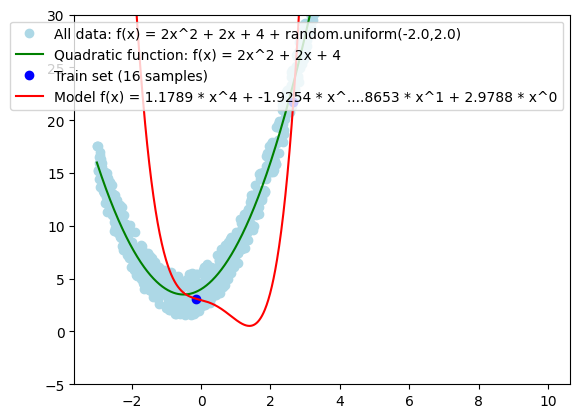

Model trained with 4 samples
Trained model f(x) = -0.0784 * x^4 + 0.4380 * x^3 + 2.1016 * x^2 + -0.1956 * x^1 + 3.0350 * x^0


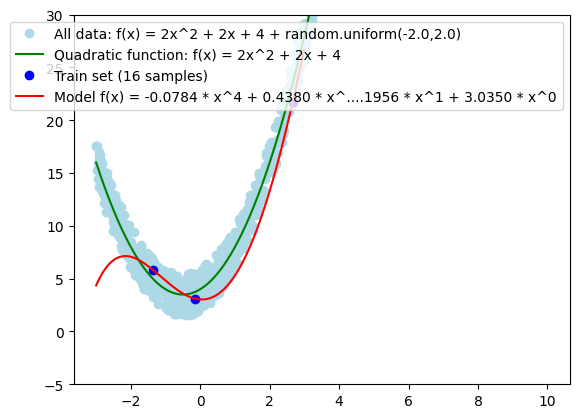

Model trained with 8 samples
Trained model f(x) = -0.1376 * x^4 + 0.9361 * x^3 + 5.8346 * x^2 + -1.9932 * x^1 + 2.5851 * x^0


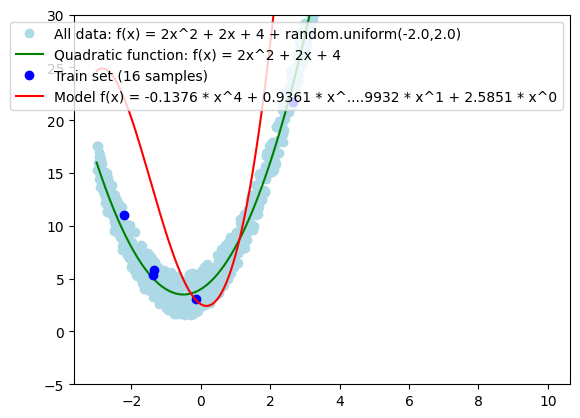

Model trained with 16 samples
Trained model f(x) = -0.0527 * x^4 + 0.5903 * x^3 + 1.4717 * x^2 + -1.2156 * x^1 + 2.9076 * x^0


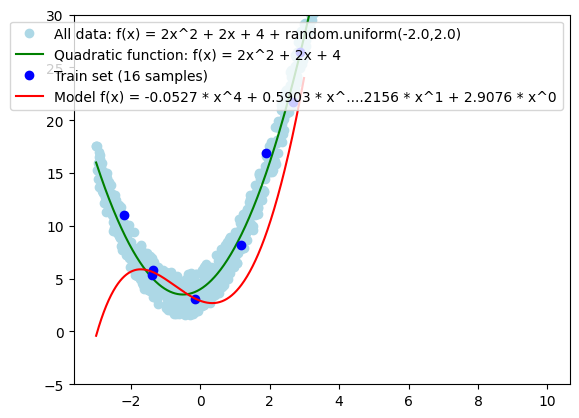

Model trained with 32 samples
Trained model f(x) = 0.0050 * x^4 + -0.0716 * x^3 + 2.2137 * x^2 + 2.2879 * x^1 + 2.9083 * x^0


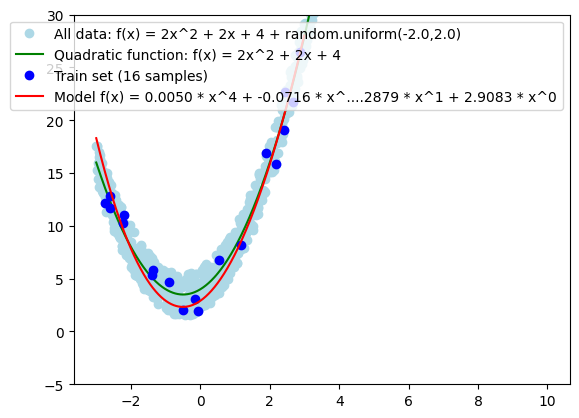

Model trained with 64 samples
Trained model f(x) = 0.0069 * x^4 + -0.4421 * x^3 + 5.4163 * x^2 + 2.1620 * x^1 + 2.6776 * x^0


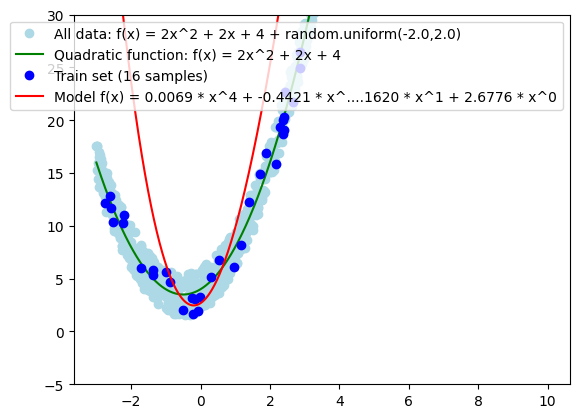

Model trained with 128 samples
Trained model f(x) = 0.0013 * x^4 + -0.0387 * x^3 + 2.2265 * x^2 + 2.1341 * x^1 + 3.7177 * x^0


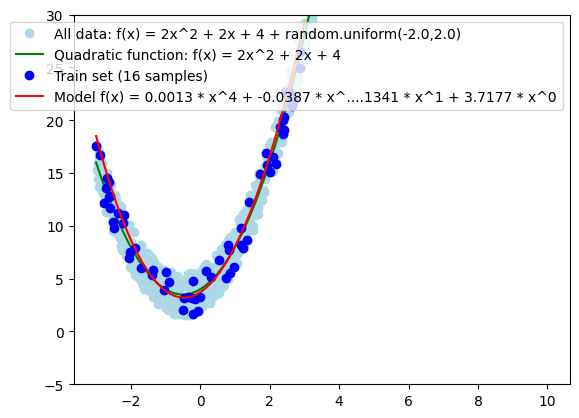

In [64]:
for nsamples in [2, 4, 8, 16, 32, 64, 128]:
    # Select the first nsamples samples
    X_train, y_train = X_200[0:nsamples], y_200[0:nsamples]
    # Train and plot the model
    train_and_plot_model(X_train, y_train, X_val, y_val, 
                         learning_rate=0.5, polynomial_degree=4, 
                         model_info = f"Model trained with {len(X_train)} samples")



Notice that as we increase the amount of training data, the model better approximates the underlying generative function.


### 5.1 Regularization techniques

Increasing the dataset size is often the most effective way to improve model generalization. 
However, in many real-world scenarios, acquiring and labeling additional data can be prohibitively expensive. 
For example, collecting X-ray images and having them annotated by specialized doctors requires significant resources and expertise, making large-scale data augmentation a challenging task.

Regularization techniques help mitigate overfitting by preventing the model from becoming too specialized to the training set. 
While there are various regularization strategies, covering them all is beyond the scope of this tutorial. 
However, to illustrate this approach, we will apply two regularization techniques to prevent our degree-4 polynomial model from overfitting: early stop and ridge regularization.

**Early stopping** is a widely used technique in deep learning models trained with gradient descent. 
It helps prevent overfitting by halting training once validation performance stops improving.

**Ridge regularization** (also known as L2 regularization) is commonly applied to polynomial models and linear regression to control model complexity and prevent overfitting by penalizing large coefficient values.


#### 5.1.1 Early stop

Early stopping is a training strategy that helps prevent overfitting by monitoring the model's performance on a validation set, which represents unseen data and is not used to update the model’s parameters. 
Instead of selecting the parameters that achieve the lowest loss on the training set, early stopping retains the parameters that yield the best validation performance.

The process is straightforward: At the end of each epoch, the model's performance on the validation set is evaluated. 
If it improves compared to previous epochs (e.g., lower validation loss or higher accuracy), the current set of parameters is saved as the best one. 
Once training is complete, the model is restored to these best-performing parameters to maximize generalization.

The following training function implements the early stopping approach. 
Notice that it is very similar to the previous ones, with one key difference: it saves the model parameters whenever the validation loss improves. 
Additionally, at the end of training, it also saves the parameters for the last epoch.

In [71]:
# This training function saves two checkpoints: 
# checkpoint_filename_prefix+best_val.pth and checkpoint_filename_prefix+last_epoch.pth
# The first one contains the parameters of the model that achieved the best validation loss, 
# while the second one contains the parameters of the last epoch.
def train_model_v3(model, 
                   X_train, y_train, 
                   X_val, y_val,
                   learning_rate = 0.001,
                   number_of_epochs = 10,
                   verbosity_skip_level = 1, # Print loss at every 'verbosity_skip_level' epochs.
                   checkpoint_filename_prefix = "model_parameters"): # checkpoint filename prefix. 

    # Create the loss function
    loss_fn = nn.L1Loss() # The L1Loss is the MAE

    # Create the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    # Create a learning rate scheduler.
    lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, 
                                                         total_iters=number_of_epochs, 
                                                         power=4.0)

    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    # Initialize the best loss
    best_loss = None
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    # Create empty loss and epoch indices lists to track values
    train_loss_values = []
    val_loss_values = []
    epoch_indices = []

    for epoch in range(number_of_epochs):
        # -- Update the parameters using the training set -- #

        # Put model in training mode (this is the default state of a model)
        model.train()
        # 1. Forward pass on train data using the forward() method inside 
        y_hat = model(X_train)
        # 2. Calculate the loss (how different are our models predictions to the ground truth)
        loss = loss_fn(y_hat, y_train)
        # 3. Zero grad of the optimizer
        optimizer.zero_grad()
        # 4. Loss backwards
        loss.backward()
        # 5. Progress the optimizer
        optimizer.step()

        # -- Check performance on validation set -- #

        # Put the model in evaluation mode
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass on test data
            val_hat = model(X_val)
            # 2. Caculate loss on test data
            val_loss = loss_fn(val_hat, y_val)

            # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
            # Save parameters if validation loss is improved
            if (best_loss == None) or (val_loss < best_loss):
                best_loss = val_loss
                print(f"Saving \"{checkpoint_filename_prefix}.best_val.pth\". Epoch = {epoch}: Validation loss = {val_loss}.")
                print(model)
                filename = checkpoint_filename_prefix+".best_val.pth"
                torch.save(obj=model.state_dict(), f=filename) 
            # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

            # Register losses
            epoch_indices.append(epoch)
            train_loss_values.append(float(loss.detach().cpu().numpy()))
            val_loss_values.append(float(val_loss.detach().cpu().numpy()))

            # (2) Adjust the learning rate at the end of each epoch
            lr_scheduler.step()

            # Print out what's happening
            if (verbosity_skip_level > 0) and (epoch % verbosity_skip_level == 0):
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Validation Loss: {val_loss} ")

    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    # Saving the parameters after the last epoch
    print(f"Saving \"{checkpoint_filename_prefix}.last_epoch.pth\". Epoch = {epoch}: Validation loss = {val_loss}.")
    print(model)
    filename = checkpoint_filename_prefix+".last_epoch.pth"
    torch.save(obj=model.state_dict(), f=filename) 
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    return epoch_indices, train_loss_values, val_loss_values

Ok, now lets train our polynomial model using only 6 training samples and 20 validation samples to verify what happens.

In [66]:
# Select only 6 samples for training
X_train, y_train = X_200[:6], y_200[:6]

# Select 20 samples for validation
X_val, y_val = X_200[-20:], y_200[-20:]


Saving "poly_4_parameters.best_val.pth". Epoch = 0: Validation loss = 1057244.0804852862.
f(x) = -856.2390 * x^4 + -70.7704 * x^3 + -3.6843 * x^2 + 0.3485 * x^1 + 0.2922 * x^0
Saving "poly_4_parameters.best_val.pth". Epoch = 1: Validation loss = 812071.2727752919.
f(x) = 649.8274 * x^4 + 110.6226 * x^3 + 20.2274 * x^2 + 3.5767 * x^1 + 1.1918 * x^0
Saving "poly_4_parameters.best_val.pth". Epoch = 3: Validation loss = 811324.102888854.
f(x) = 649.2254 * x^4 + 110.5490 * x^3 + 20.2245 * x^2 + 3.5304 * x^1 + 1.4912 * x^0
Saving "poly_4_parameters.best_val.pth". Epoch = 5: Validation loss = 810577.3812678752.
f(x) = 648.6237 * x^4 + 110.4755 * x^3 + 20.2217 * x^2 + 3.4842 * x^1 + 1.7904 * x^0
Saving "poly_4_parameters.best_val.pth". Epoch = 7: Validation loss = 809831.1077330515.
f(x) = 648.0223 * x^4 + 110.4021 * x^3 + 20.2189 * x^2 + 3.4380 * x^1 + 2.0893 * x^0
Saving "poly_4_parameters.best_val.pth". Epoch = 9: Validation loss = 809085.2821051149.
f(x) = 647.4213 * x^4 + 110.3287 * x^3 +

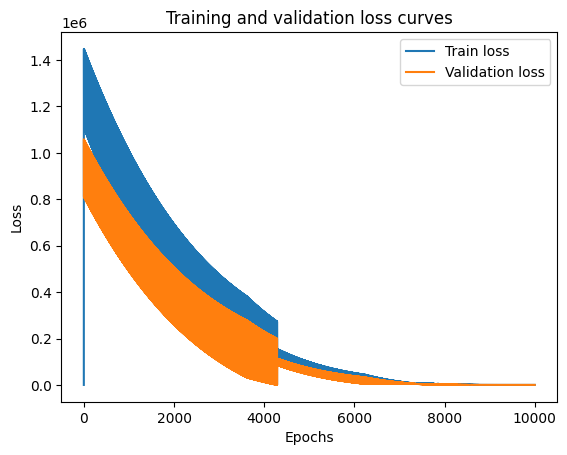

In [67]:
# Create the model
set_seed(1969)
model = PolynomialRegressionModel(polynomial_degree=4).to(device)


# Train the model
epoch_indices, train_losses, val_losses = train_model_v3(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                                                         learning_rate=0.9,
                                                         number_of_epochs = 10000, verbosity_skip_level = 0,
                                                         checkpoint_filename_prefix="poly_4_parameters")

# Plot the loss curves
plt.plot(epoch_indices, train_losses, label="Train loss")
plt.plot(epoch_indices, val_losses, label="Validation loss")
plt.title("Training and validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


Notice that, despite the oscilation, the validation loss decreases at first and, then, it increases. 
As discussed before, it increases because the model is specializing too much for the training set. 

Now, lets see the difference between the model with "best_val" parameteres (parameters that achieved best validation loss) and the "last_epoch" parameters (parameters after the 10000 epochs).

Model with best validation parameters f(x) = -0.4364 * x^4 + 2.5251 * x^3 + 15.0969 * x^2 + -6.5302 * x^1 + 1.6081 * x^0


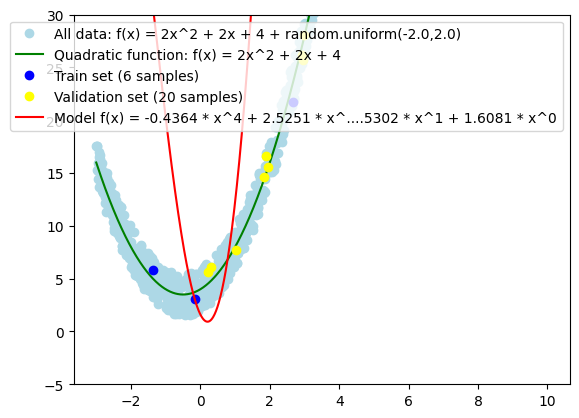

Model with parameters from last epoch f(x) = -0.3987 * x^4 + 2.4672 * x^3 + 15.0774 * x^2 + -6.5344 * x^1 + 1.6069 * x^0


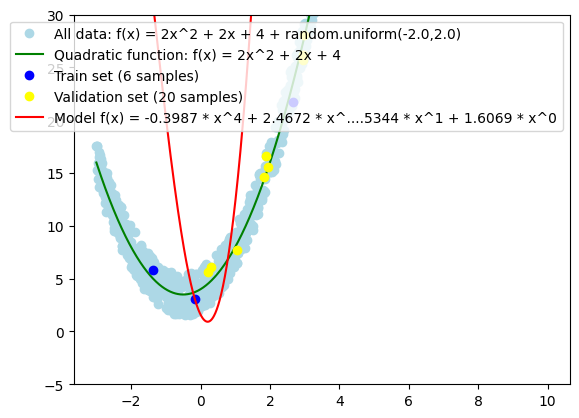

In [68]:
# Create model and load parameters that achieved the best validation loss
model_best_val = PolynomialRegressionModel(polynomial_degree=4).to(device)
model_best_val.load_state_dict(torch.load(f="poly_4_parameters.best_val.pth"))

print("Model with best validation parameters", str(model_best_val))
plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        model_line=(-3.0,3.0,0.01,model_best_val), yrange=(-5,30))


# Create model and load parameters from last epoch 
model_last_epoch = PolynomialRegressionModel(polynomial_degree=4).to(device)
model_last_epoch.load_state_dict(torch.load(f="poly_4_parameters.last_epoch.pth"))

print("Model with parameters from last epoch", str(model_last_epoch))
plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                        val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                        background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                        background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                        model_line=(-3.0,3.0,0.01,model_last_epoch), yrange=(-5,30))


Notice that the first model (**best_val**) provides a better fit to the validation data and more closely aligns with the underlying generative function while the second one specializes to the training set.

#### 5.1.2 Ridge regularization

Ridge regularization, also known as L2 regularization, is a technique used to prevent overfitting in machine learning models by adding a penalty term to the loss function. 
This penalty discourages the model from assigning excessively large weights (parameters), leading to a more stable and generalizable models.

In our previous experiments, we trained our polynomial model using the MAE (L1) loss function, as follows:

$ \mathcal{L} = \sum_{i=1}^{n} |y_i - \hat{y}_i|$ 

Also, our polynomial model implements the following function:

$f(x) = p_d \times x^{d} + p_{d-1} \times x^{d-1} + \cdots + p_{1} \times x^{1} + p_{0} \times x^{0}$

To introduce the ridge regularization, we add a new component to the loss function that considers the polynomial coefficients:

$ \mathcal{L} = \sum_{i=1}^{n} |y_i - \hat{y}_i| + \lambda \sum_{j=1}^{d} p_j^2 $ 

It is well known that regularizing the constant parameter ($p_0$) is not a good practice, as it does not contribute to the model’s complexity. 
Therefore, the summation for the regularization term starts at $j=1$, instead of 0.

The following training function is a modified version of our previous function, now incorporating ridge regularization.


In [69]:
def train_model_ridge(model, 
                      X_train, y_train, 
                      X_val, y_val,
                      learning_rate = 0.001,
                      ridge_lambda = 1.0,
                      number_of_epochs = 10,
                      verbosity_skip_level = 1): # Print loss at every 'verbosity_skip_level' epochs.

    # Create the loss function
    loss_fn = nn.L1Loss() # The L1Loss is the MAE

    # Create the optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

    # Create a learning rate (LR) scheduler.
    lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, 
                                                         total_iters=number_of_epochs, 
                                                         power=4.0)

    # Create empty loss and epoch indices lists to track values
    train_loss_values = []
    val_loss_values = []
    epoch_indices = []

    for epoch in range(number_of_epochs):
        # -- Update the parameters using the training set -- #

        # Put model in training mode (this is the default state of a model)
        model.train()
        # 1. Forward pass on train data using the forward() method inside 
        y_hat = model(X_train)
        # 2. Calculate the loss (how different are our models predictions to the ground truth)
        # loss = loss_fn(y_hat, y_train)
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        parameter_l2_norm = torch.zeros(size=(1,), device=X_train.device)
        for i in range(1, model.d+1):
            parameter_l2_norm = parameter_l2_norm + model.coefficients[i]*model.coefficients[i] # p_i^2
        loss = loss_fn(y_hat, y_train) + ridge_lambda * parameter_l2_norm
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        # 3. Zero grad of the optimizer
        optimizer.zero_grad()
        # 4. Loss backwards
        loss.backward()
        # 5. Progress the optimizer
        optimizer.step()

        # -- Check performance on validation set -- #

        # Put the model in evaluation mode
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass on test data
            val_hat = model(X_val)
            # 2. Caculate loss on test data
            val_loss = loss_fn(val_hat, y_val.type(torch.float))
            epoch_indices.append(epoch)
            train_loss_values.append(float(loss.detach().cpu().numpy()))
            val_loss_values.append(float(val_loss.detach().cpu().numpy()))

            # (2) Adjust the learning rate at the end of each epoch
            lr_scheduler.step()

            # Print out what's happening
            if (verbosity_skip_level > 0) and (epoch % verbosity_skip_level == 0):
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Validation Loss: {val_loss} ")

    return epoch_indices, train_loss_values, val_loss_values

Notice that the `ridge_lambda` parameter controls the strength of the regularization term in the loss function. 
A higher `ridge_lambda` value increases the penalty on large coefficients, pushing them toward smaller values.
Since it directly influences model complexity, `ridge_lambda` is treated as a hyperparameter in the training process.

Now, lets train our model using different `ridge_lambda` values and check how it affects the final model.

/tmp/ipykernel_15254/3050178655.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_loss_values.append(float(loss.detach().cpu().numpy()))


** Model regularized with ridge_lambda = 0.0 **
   Model equation: f(x) = -0.0401 * x^4 + 0.4596 * x^3 + 1.5637 * x^2 + -1.0013 * x^1 + 2.9262 * x^0


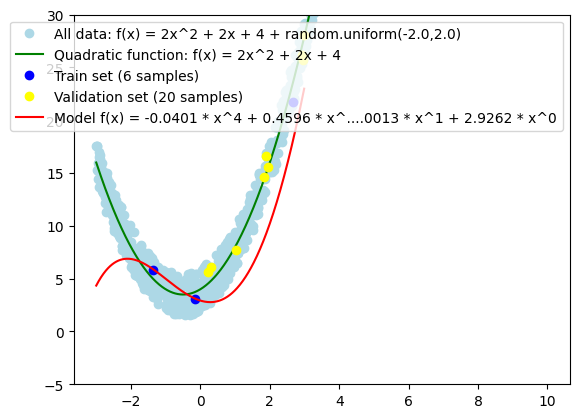

** Model regularized with ridge_lambda = 0.1 **
   Model equation: f(x) = -0.0033 * x^4 + 0.2275 * x^3 + 0.3796 * x^2 + -0.0527 * x^1 + 3.1307 * x^0


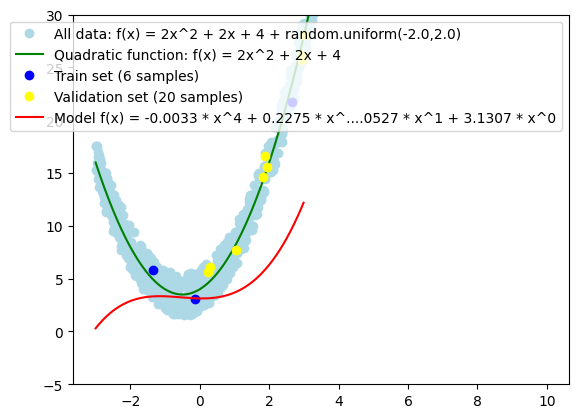

** Model regularized with ridge_lambda = 1.0 **
   Model equation: f(x) = -0.0056 * x^4 + 0.2601 * x^3 + 0.2756 * x^2 + -0.0184 * x^1 + 3.1297 * x^0


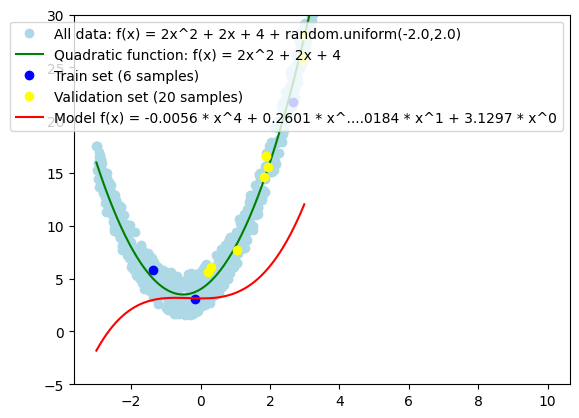

In [70]:
# For different values of the `ridge_lambda` hyperparameter
for ridge_lambda in [0.0, 0.1, 1.0]:

    # Create the model
    set_seed(1969)
    model = PolynomialRegressionModel(polynomial_degree=4).to(device)

    # Train the model using the given `ridge_lambda`` hyperparameter
    epoch_indices, train_losses, val_losses = train_model_ridge(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                                                            learning_rate=0.1,
                                                            number_of_epochs = 10000, verbosity_skip_level = 0,
                                                            ridge_lambda=ridge_lambda)

    print(f"** Model regularized with ridge_lambda = {ridge_lambda} **")
    print("   Model equation:", str(model))
    plot_dataset_samples_v3(train_samples=(X_train,y_train,f"Train set ({len(X_train)} samples)"),
                            val_samples=(X_val,y_val,f"Validation set ({len(X_val)} samples)"),
                            background_samples=(X_all,y_all,"All data: f(x) = 2x^2 + 2x + 4 + random.uniform(-2.0,2.0)"), 
                            background_line=(X_all,y_all_clean,"Quadratic function: f(x) = 2x^2 + 2x + 4"),
                            model_line=(-3.0,3.0,0.01,model), yrange=(-5,30))


We can see that a larger `ridge_lambda` hyperparameter results in a smoother model.

## Exercises

There is no designated exercise for this tutorial. 
However, you can gain valuable insights by modifying the code, adjusting hyperparameters, changing dataset sizes, and experimenting with different configurations.
